# Amorim-Hennig clustering
## AKA iMWK-Means with explicit rescaling followed by K-Means

This clustering method is developed and explained in 
De Amorim, R. C. & Hennig, C. Recovering the number of clusters in data sets with noise features using feature rescaling factors. Inf. Sci. (Ny). 324, 126–145 (2015).

The description here follows the development as described in that paper, often copying shamelessly.

In this notebook, I explain the historical development of this clustering method. While this may seem overly complicated, going through the development starting with K-Means clustering makes the final clustering algorithm seems a little less unwieldy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
from sklearn.cluster import KMeans
%matplotlib inline

# Toy data

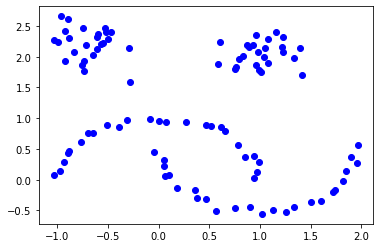

In [2]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b')

## K-Means clustering
Let $Y$ be a $V$-dimensional data set with $y_i \in Y$ for $i=1,2,\dots,N$. K-means clustery generates K non-empty, disjoint clusters $S={S_1,S_2,\dots,S_k}$ with centroids $C={c_1,c_2,\dots,c_k}$ by iterative minimization of
<center>$W_K = W(S,C)=\sum_k\sum_{y_i\in S_k}d(y_i,c_k)$</center>
where $d$ is a metric -- typically Euclidean. For the general case of Minkowski distances, we write $d_p(y_i,c_k)=\sum_{v\in V}|y_{iv}-c_{kv}|^p$, where $p$ is called the *Minkowski weight*.

$W_K$ is called the K-Means criterion and serves as a score for the clustering with a lower number being better.

<ipython-input-3-895747f3bfc0>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(test_data.T[0], test_data.T[1], c=labels.astype(np.float))
<ipython-input-3-895747f3bfc0>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(test_data.T[0], test_data.T[1], c=labels.astype(np.float))
<ipython-input-3-895747f3bfc0>:13: Dep

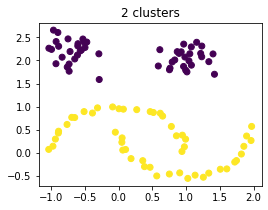

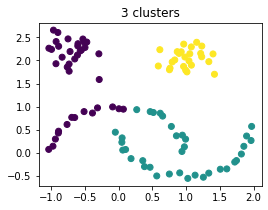

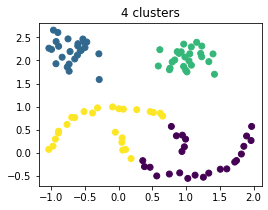

In [3]:
estimators = [('k_means_2', KMeans(n_clusters=2)),
              ('k_means_3', KMeans(n_clusters=3)),
              ('k_means_4', KMeans(n_clusters=4))]

fignum = 1
titles = ['2 clusters', '3 clusters', '4 clusters']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = fig.add_subplot(1,1,1)
    est.fit(test_data)
    labels = est.labels_

    ax.scatter(test_data.T[0], test_data.T[1], c=labels.astype(np.float))

    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1


## Estimating K
We may not know $K$ *a priori*, so we need something to estimate or optimize K. There are many *Cluster Validity Indexes* or CVIs that could be optimized. The code in our repository uses the Silhouette index
<center>$s(y_i) = \frac{b(y_i)-a(y_i)}{\max\left[a(y_i),b(y_i)\right]} $</center>
where $a(y_i)$ is the average dissimilarity of $y_i\in S_k$ to all other $y_j \in S_k$ and $b(y_i)$ is the minimum dissimilarity over all clusters $S_l$, to which $y_i$ is not assigned, of the average dissimilarities to $y_j\in S_l, l\neq k$. It will be true that $-1\leq s(y_i)\leq 1$. If $s(y_i)\approx 0$, the entity $y_i$ could be assigned to another cluster without making the clustering worse. Negative $s(y_i)$ suggests $y_i$'s cluster label is making the overall clustering worse, and positive means the opposite. The silhouette score for a given clustering of the entire data set is then 
<center>$\frac{1}{N}\sum_{i\in Y}s(y_i) $</center>

### iK-Means (Intelligent K-Means)
One method designed to pick a good (well-scoring) K is iK-Means. For a fixed parameter $\theta$ (representing minimum accepted initial cluster size),
1. Set $c_c = \bar{y}$, the center of data set $Y$ .
2. Set $c_t = \text{arg max} d(c_i,c_c)$, the farthest entity $y_i \in Y$ from $c_c$.
3. Run K-Means supplying $c_c$ and $c_t$ as initial centroids, forming clusters $S_c$
and $S_t$. The aim is to find a cluster $S_t$ anomalous in relation to $c_c$, hence
the latter should not be allowed to move during the K-Means iterations while $c_c$ is kept fixed.
4. If $|S_t| \geq \theta$, $|S_t|$ denoting the number of elements of $S_t$, add $c_t$ to $C_\text{init}$ -- the set of initial centroids. In any case remove the entities $y_i \in S_t$ from $Y$.
5. If there are still entities to cluster, go to Step 2.
6. Run K-Means using the centroids in $C_\text{init}$ as initial centroids and set $K= |C_\text{init}|$.

## K-Means with feature weighting
The Minkowski metric is defined
<center>$ d_p(y_i,c_k)=\left(\sum_{v \in V} \left|y_{iv}-c_{kv} \right|^p\right)^\frac{1}{p} $</center>
for V-dimensional $y_i$ and $c_k$.

The weighted Minkowski distance is 
<center> $d_p(y_i,c_k)=\sum_{v\in V}w^p_{kv}|y_{iv}-c_{kv}|^p$ </center>
with weights $w$ to be derived later.

This distance gives rise to MWK-Means (Minkowski Weighted ...) with criterion
<center>$W_p = W(S,C,w)=\sum_k\sum_{y_i\in S_k}\sum_{v}w^p_{kv}|y_{iv}-c_{kv}|^p,$</center>
subject to $\sum_{v\in V}w_{kv}=1$ with $w_{kv}$ representing the weihgt of a particular feature $v$ in cluster $S_k$.

Define the feature dispersion of variable $v$ in cluster $k$ as $D_{kv} =\sum_{y_i \in S_k}|y_{iv}-c_{kv}|^p$. From this we assign weights
<center> $w_{kv}=\frac{1}{\sum_{u\in v}\left[D_{kv}/D_{ku}\right]^{1/(p-1)}}$ </center>

We then minimuze $W_p$ iteratively to calculate a Minkowski-weighted K-Means clustering. Beyond standardizing data, it may not be the case that all features *should* be weighted equally. Therefore, to account for the dispersion a given feature may introduce, we include a condition for the Lagrange function L
<center>$L=\sum_{v\in V} w_{kv}^p D_{kv}+\lambda\left(1-\sum_{v\in V}w_{kv}\right)$</center>
and optimize as per usual calculus.

## iMWK-Means
For a fixed parameter $\theta$ (representing minimum accepted initial cluster size) and Minkowski distance (as defined above, i.e., select $p$),
1. Standardize the data in $Y$
2. Set $c_c = \bar{y}$, the Minkowski center of data set $Y$ and each $w_{kv} =\frac{1}{|V|}$ .
3. Set $c_t = \text{arg max} d_p(c_i,c_c)$, the farthest entity $y_i \in Y$ from $c_c$.
4. Run MWK-Means supplying $c_c$ and $c_t$ as initial centroids, forming clusters $S_c$
and $S_t$ while $c_c$ is kept fixed.
5. If $|S_t| \geq \theta$, add $c_t$ to $C_\text{init}$ and the weight $w$ yielded by MWK-Means to $W_\text{init}$. In any case remove the entities $y_i \in S_t$ from $Y$.
6. If there are still entities to cluster, go to Step 2.
7. Run MWK-Means using the centroids in $C_\text{init}$ as initial centroids, the initial weights in $W_\text{init}$  and set $K= |C_\text{init}|$.

In practice, rather than setting $K= |C_\text{init}|$, you can set $\theta=1$ and run iMWK-Means once for each $K\in[2,\dots,\min(|C_\text{init}|, 20)]$ and pick the K with the best CVI.

## iMWK-Means with explicit rescaling
1. Run iMWK-Means. For $K in [2, . . . , \min(|C_\text{init}|, 20)]$:

    (a) Generate $Y_w$ and $C_w$ as specified below.

    (b) Apply a given CVI using $Y_w$, $C_w$ and the clustering generated by iMWK-Means with $K$ fixed.
    
    (c) Increment K by one.

$Y_w$ denotes the re-scaled version of the data set $Y$. We represent the value
of a feature $v$ in a particular entity $y_i$
in $Y_w$ by $y_{ivw}$. Given clustering $S =
[S_1, S_2, ..., S_K]$ produced by iMWK-Means at a given $K$, we obtain $Y_w$ by
setting each $y_{ivw} \in S_k$ to $y_{iv}w_{kv}$, for each cluster $S_k \in S$ (to be understood as
including the initial standardisation).

Similarly, $C_w$ contains the re-scaled centroids $c_w$ defined by $c_{kvw} = c_{kv}w_{kv}$
for $c_k \in C$. Our data re-scaling process takes into account the relative dispersion
of each feature $v$ in each cluster $S_k$. We find this to be a considerably better way
to re-scale features than using equations that trea

## iMWK-Means with explicit rescaling
1. Run iMWK-Means. For $K \in [2, \dots , \min(|C_\text{init}|, 20)]$:

    (a) Generate $Y_w$.
    
    (b) Apply K-Means to $Y_w$ from random initialisations $q$ times (e.g., $q = 100$), disregarding all clusterings but the one returning thes mallest K-Means criterion output.
    (c) Apply a given CVI using $Y_w$, as well as the clustering generated by
    K-Means.
    (d) Increment $K$ by one.